# Construction and Test of DNN

In [1]:
import sys
sys.path.insert(0, '../')  # Notebook is in the 'notebooks' directory
from src.dbn import init_DBN, train_DBN
from src.rbm import entree_sortie_rbm
import numpy as np
from matplotlib import pyplot as plt
from src.data_utils import lire_alpha_digit
from src.dbn import DBN
from src.rbm import RBM
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sns

In [2]:
def init_DNN(sizes, output_size=10):
    """
    Initialize a Deep Neural Network (DNN) with the given sizes and output size.
    param: sizes: list of integers representing the number of nodes in each layer
    param: output_size: number of nodes in the output layer
    return: the initialized DNN model
    """
    configuration = sizes + [output_size]
    print(configuration)
    return init_DBN(configuration)

In [3]:
# Load the data
data_path = '../data/binary_alpha_digits/binaryalphadigs.mat'
X = lire_alpha_digit(data_path, np.arange(5))
y_labels = []
for i in range(5):
    y_labels.extend([i] * (X.shape[0] // 5))
y = np.array(y_labels)
X.shape, y.shape

((195, 320), (195,))

In [14]:
dnn = init_DNN([320, 200, 200],5)
print(len(dnn), dnn[0]['W'].shape)

[320, 200, 200, 5]
3 (320, 200)


In [5]:
def pretrain_DNN(X, dnn, epochs=100, learning_rate=0.1, batch_size=128):
    """
    Pretrain a Deep Neural Network (DNN) using the given data.
    param: X: training data
    param: dnn: the DNN model
    param: epochs: number of training epochs
    param: learning_rate: learning rate
    param: batch_size: size of mini-batches
    return: the pretrained DNN model
    """
    dbn = dnn[:-1]
    dbn = train_DBN(X, dbn, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    dnn[:-1] = dbn
    return dnn

In [15]:
dnn = pretrain_DNN(X, dnn, epochs=100, learning_rate=0.1, batch_size=32)

Training layer 1
Training layer 2


In [7]:
def calcul_softmax(rbm, X):
    """
    Calculate the softmax probabilities for the given layer and input data.
    param: layer: a dictionary containing the weights 'W' and biases 'b' of the layer
    param: X: input data
    return: softmax probabilities
    """
    # Calculate the logits
    logits = np.dot(X, rbm['W']) + rbm['b']
    
    # Apply the softmax function
    exp_logits = np.exp(logits)
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    return softmax_probs

In [8]:
def entree_sortie_reseau(DNN, X):
    """
    Compute the output of the Deep Neural Network (DNN) given the input.
    param: DNN: the DNN model
    param: X: the input data
    return: the output of the DNN
    """
    v = X.copy()
    sorties = [X]  # List to store the outputs of each layer
    proba_sortie = None  # Will store the output of the last layer
    
    for i in range(len(DNN)-1):
        rbm = DNN[i]
        p_h = entree_sortie_rbm(rbm, v)
        v = np.random.binomial(1, p_h)
        sorties.append(p_h)
    rbm_classification = DNN[-1]
    proba_sortie = calcul_softmax(rbm_classification, v)
    
    return sorties, proba_sortie

In [9]:
sorties, proba_sortie = entree_sortie_reseau(dnn, X)

In [10]:
sorties[0].shape, proba_sortie.shape

((195, 320), (195, 5))

In [13]:
def retropropagation(X, y, dnn, epochs=100, learning_rate=0.1, batch_size=128, verbose=True, plot=True, pretrained=False, save_path=None):
    """
    Train a Deep Neural Network (DNN) using the given data.
    param: X: training data
    param: y: target labels
    param: dnn: the DNN model
    param: pretrained: whether the DNN is pretrained
    param: epochs: number of training epochs
    param: learning_rate: learning rate
    param: batch_size: size of mini-batches
    param: verbose: whether to print the loss at each epoch
    param: plot: whether to plot the loss
    return: the trained DNN model"""
    # Convert y to one-hot encoded format using pd.get_dummies
    y_one_hot = pd.get_dummies(y).values

    best_loss = float('inf')  # Initialize the minimum loss to infinity
    loss = []
    patience = 5  # Number of epochs to wait before early stopping
    wait = 0
    
    for epoch in range(epochs):
        # Shuffle the data using sklearn shuffle
        X_shuffled, y_shuffled = shuffle(X, y_one_hot)
        
        loss_batches = []
        # Iterate over each mini-batch
        for batch in range(0, X.shape[0], batch_size):
            
            X_batch = X_shuffled[batch: min(batch + batch_size, X.shape[0]), :]
            y_batch = y_shuffled[batch: min(batch + batch_size, X.shape[0])]

            # Forward propagation
            sorties, proba_sortie = entree_sortie_reseau(dnn, X_batch)
            

            # Loss calculation
            loss_batch = -np.mean(np.sum(y_batch * np.log(proba_sortie), axis=1))
            loss_batches.append(loss_batch)
            
            # Backward propagation
            # Last layer
            delta = proba_sortie - y_batch
            grad_W = np.dot(sorties[-1].T, delta) / batch_size
            grad_b = np.mean(delta, axis=0)
            dnn[-1]['W'] -= learning_rate * grad_W
            dnn[-1]['b'] -= learning_rate * grad_b

            # Hidden layers
            for i in range(2, len(dnn)+1):
                if i == 2:  # Classification layer
                    RBM = dnn[-1]
                    delta = np.dot(delta, RBM['W'].T) * sorties[-1] * (1 - sorties[-1])
                else:
                    RBM = dnn[-i+1]
                    delta = np.dot(delta, RBM['W'].T) * sorties[-i+1] * (1 - sorties[-i+1])
                if i == len(dnn):
                    grad_W = np.dot(X_batch.T, delta)
                else:
                    grad_W = np.dot(sorties[-i].T, delta)
                
                grad_b = np.mean(delta, axis=0)
    
                # Update weights and biases
                dnn[-i]['W'] -= learning_rate * grad_W
                dnn[-i]['b'] -= learning_rate * grad_b


        # Calculate the cross entropy loss for the epoch
        train_loss = float(np.mean(loss_batches))
        loss.append(train_loss)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}")

        # Check if current loss is less than the best loss encountered so far
        if train_loss < best_loss:
            best_loss = train_loss
            wait = 0  # reset wait since we've seen improvement
        else:
            wait += 1  # increment wait since there was no improvement

        # If we have waited for 'patience' epochs without improvement, stop training
        if wait >= patience:
            print("Early stopping due to no improvement in Loss.")
            break
        
          
    
    if plot:
        plt.figure()
        plt.plot(np.arange(len(loss)), loss)
        plt.xlabel("Epochs")
        plt.ylabel("CrossEntropy Loss")
        if pretrained:
            plt.title("Loss for pretrained DNN")
        else:
            plt.title("Loss for DNN (without pretraining)")
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show(block=False)
        plt.close()
    return dnn

Epoch 1/100, Loss: 1.4518189084353037
Epoch 2/100, Loss: 0.6741915895679768
Epoch 3/100, Loss: 0.43088641524578347
Epoch 4/100, Loss: 0.31438617774028227
Epoch 5/100, Loss: 0.212030573502847
Epoch 6/100, Loss: 0.16539310044022595
Epoch 7/100, Loss: 0.13788729948995596
Epoch 8/100, Loss: 0.13319312740666892
Epoch 9/100, Loss: 0.09686042464646114
Epoch 10/100, Loss: 0.10083071605247314
Epoch 11/100, Loss: 0.08443527710672492
Epoch 12/100, Loss: 0.08387230773382505
Epoch 13/100, Loss: 0.06193735300386132
Epoch 14/100, Loss: 0.056146413239720604
Epoch 15/100, Loss: 0.05268379885848223
Epoch 16/100, Loss: 0.04841399774633747
Epoch 17/100, Loss: 0.046854184635404014
Epoch 18/100, Loss: 0.043600557656936975
Epoch 19/100, Loss: 0.034430054112001236
Epoch 20/100, Loss: 0.03749148149137246
Epoch 21/100, Loss: 0.036658330622352665
Epoch 22/100, Loss: 0.03449197123319718
Epoch 23/100, Loss: 0.026343284678241853
Epoch 24/100, Loss: 0.030868214858867715
Epoch 25/100, Loss: 0.02604671057219074
Epoch 

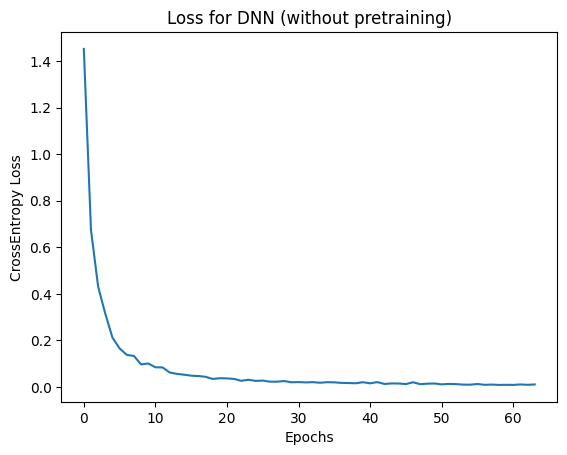

In [16]:
dnn = retropropagation(X, y, dnn, epochs=100, learning_rate=0.1, batch_size=32)

In [13]:
def test_dnn(X, y, dnn, verbose=False):
    _, proba_sortie = entree_sortie_reseau(dnn, X)
    predictions = np.argmax(proba_sortie, axis=1)
    accuracy = np.mean(predictions == y)
    if verbose :
        print(f"Accuracy: {accuracy}")
    return accuracy

In [14]:
def box_plot_proba(data, dnn, k, save_path=None):
    _, proba_sortie = entree_sortie_reseau(dnn, data)
    plt.figure()
    sns.boxplot(data=proba_sortie)
    plt.xlabel("Classes")
    plt.ylabel("Predicted probability")
    plt.title("Distribution of probabilities of the class {k}")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show(block=False)
    plt.close()